# 👹 End-to-end Multi class Mythological Beast classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the mythological creature name given an image of a creature.

When submitting photo of creature, I can get to know the creature name from ml model.

## 2. Data

The data we're using is from created by me and photos are downloaded from Google.

## 3. Evaluation

The evaluation is a file with prediction probabilites for each creature name identification competition.

## 4. Features

Some information about the data:
  * We're dealing with images (unstructred data) so it's probably the best we use deep learning/transfer learning.
  * There are 5 different creature's  (this means there are 5 different classes).
  * There are 100 images in training sets(these images have labels).
  * There are around 10 to 20 images in testing sets(these images have no label, because we need to predict them).
  


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Getting our workspace ready.

1. Install and then import Tensorflow 2.x
2. Install and then import Tensorflow Hub
3. Varyfing for using a GPU

In [ ]:
!pip install --upgrade tensorflow tensorflow-hub

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
print("Tensorflow version", tf.__version__)
print("Tensorflow hub", hub.__version__)

#Check for GPU availability
print("GPU", "is available" if tf.config.list_physical_devices("GPU") else "not available")

Tensorflow version 2.17.0
Tensorflow hub 0.16.1
GPU is available


## Getting our data ready(turning into tensors)

With all machine learning models, our data has to be in numerical format. So that's what we need to do first. Turning our images into tensors(numerical representations).

In [ ]:
model_path = "drive/MyDrive/mytho-beast-cnn"

In [ ]:
import csv

# Define the data
groups = ['Centaur', 'Griffin', 'Hydra', 'Minotaur', 'Pegasus']
rows = []

for group in groups:
    for i in range(1, 21):  # 5 entries for each group
        rows.append([f"{group}_{i}", group])
# Specify the directory where you want to save the file
save_path = model_path+'/labels.csv'

# Writing to CSV
with open(save_path, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['id', 'creature'])  # Writing the header
    writer.writerows(rows)  # Writing the rows

print("CSV file 'labels.csv' created successfully.")


CSV file 'labels.csv' created successfully.


In [ ]:
# Checkout the labels of our data

import pandas as pd

labels_csv = pd.read_csv(model_path+"/labels.csv")
labels_csv.describe()


id creature
count         100      100
unique        100        5
top     Centaur_1  Centaur
freq            1       20

In [ ]:
labels_csv.head()

id creature
0  Centaur_1  Centaur
1  Centaur_2  Centaur
2  Centaur_3  Centaur
3  Centaur_4  Centaur
4  Centaur_5  Centaur

In [ ]:
# How many images are there of each type?
labels_csv["creature"].value_counts()

creature
Centaur     20
Griffin     20
Hydra       20
Minotaur    20
Pegasus     20
Name: count, dtype: int64

<Axes: xlabel='creature'>

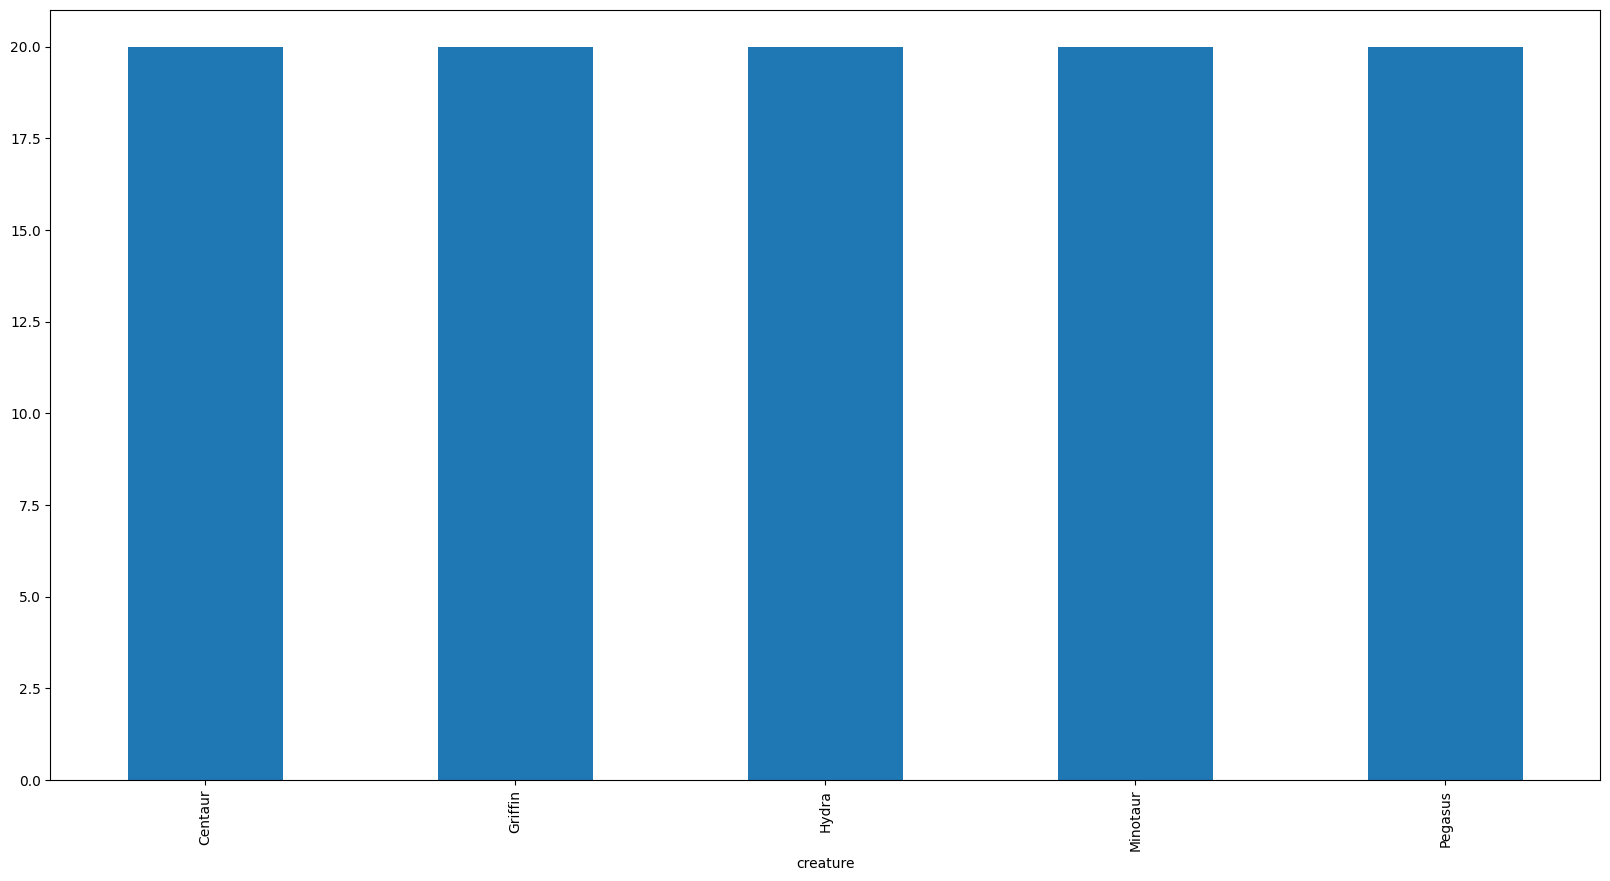

In [ ]:
labels_csv["creature"].value_counts().plot.bar(figsize=(20,10))

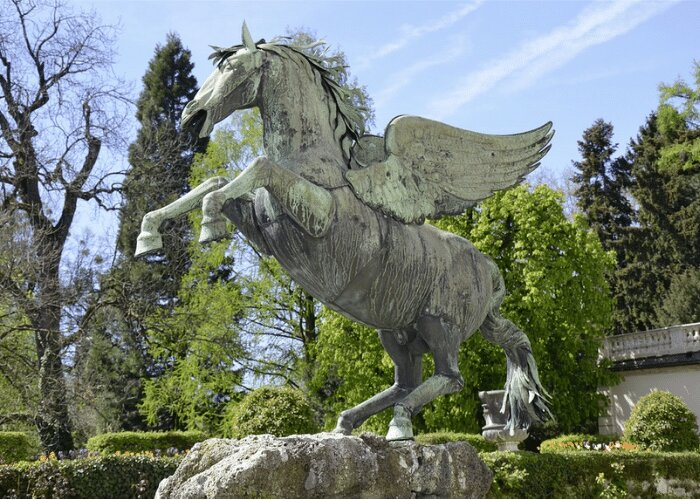

In [ ]:
# Let's view an Image

from IPython.display import Image
Image(model_path+"/train/Pegasus_17.jpg")

## Getting images and their labels.

Let's get a list of all our image file pathnames.

In [ ]:
filenames = [model_path+"/train/"+fname+".jpg" for fname in labels_csv["id"]]


print(len(filenames))

100


In [ ]:
import numpy as np

labels = labels_csv["creature"]

labels = np.array(labels)
labels

array(['Centaur', 'Centaur', 'Centaur', 'Centaur', 'Centaur', 'Centaur',
       'Centaur', 'Centaur', 'Centaur', 'Centaur', 'Centaur', 'Centaur',
       'Centaur', 'Centaur', 'Centaur', 'Centaur', 'Centaur', 'Centaur',
       'Centaur', 'Centaur', 'Griffin', 'Griffin', 'Griffin', 'Griffin',
       'Griffin', 'Griffin', 'Griffin', 'Griffin', 'Griffin', 'Griffin',
       'Griffin', 'Griffin', 'Griffin', 'Griffin', 'Griffin', 'Griffin',
       'Griffin', 'Griffin', 'Griffin', 'Griffin', 'Hydra', 'Hydra',
       'Hydra', 'Hydra', 'Hydra', 'Hydra', 'Hydra', 'Hydra', 'Hydra',
       'Hydra', 'Hydra', 'Hydra', 'Hydra', 'Hydra', 'Hydra', 'Hydra',
       'Hydra', 'Hydra', 'Hydra', 'Hydra', 'Minotaur', 'Minotaur',
       'Minotaur', 'Minotaur', 'Minotaur', 'Minotaur', 'Minotaur',
       'Minotaur', 'Minotaur', 'Minotaur', 'Minotaur', 'Minotaur',
       'Minotaur', 'Minotaur', 'Minotaur', 'Minotaur', 'Minotaur',
       'Minotaur', 'Minotaur', 'Minotaur', 'Pegasus', 'Pegasus',
       'Pegasus', 'P

In [ ]:
# find the unique label values
unique_labels = np.unique(labels)

unique_labels

array(['Centaur', 'Griffin', 'Hydra', 'Minotaur', 'Pegasus'], dtype=object)

In [ ]:
# Turning a single labels into an array of booleans

print(labels[0])

labels[0] == unique_labels

Centaur


array([ True, False, False, False, False])

In [ ]:
# Turning every label into a boolean array

boolean_labels = [label == unique_labels for label in labels]

boolean_labels[:2]

[array([ True, False, False, False, False]),
 array([ True, False, False, False, False])]

In [ ]:
len(boolean_labels)

100

In [ ]:
# Example: Turning boolean array into integers

print(labels[0]) #Original labels
print(np.where(unique_labels == labels[0])) #index where label occurs
print(boolean_labels[0].argmax()) #index where label occurs in boolean array
print(boolean_labels[0].astype(int)) #there will be a 1 where the sample label occurs

Centaur
(array([0]),)
0
[1 0 0 0 0]


## Creating our own validations set

Since we don't have validation set, we need to create our own.

In [ ]:
# Setup X and Y variables

x = filenames
y = boolean_labels

### We're going to start with 100 images

In [ ]:
# Set number of images to use for exprementing

NUM_IMAGES = 100 #@param {type:"slider", min:10, max:100, step: 10}

In [ ]:
# Let's split our data into train and validations sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size of NUM_IMAGES
x_train, x_val, y_train, y_val = train_test_split(
    x[:NUM_IMAGES],
    y[:NUM_IMAGES],
    test_size=0.2,
    random_state=42
)

len(x_train), len(y_train), len(x_val), len(y_val)

(80, 80, 20, 20)

In [ ]:
#Let's see the training data

x_train[:5], y_train[:2]

(['drive/MyDrive/Mythological Beast CNN/train/Hydra_16.jpg',
  'drive/MyDrive/Mythological Beast CNN/train/Pegasus_9.jpg',
  'drive/MyDrive/Mythological Beast CNN/train/Griffin_7.jpg',
  'drive/MyDrive/Mythological Beast CNN/train/Hydra_3.jpg',
  'drive/MyDrive/Mythological Beast CNN/train/Minotaur_10.jpg'],
 [array([False, False,  True, False, False]),
  array([False, False, False, False,  True])])

## Preprocessing Images (turning images into tensors)

To preprocess our images into tensors we're going to write a function which does a few things:
1. Take an image file path as input
2. Use TensorFlow to read the file and save it to the variable, `image`
3. Turn our `image`(jpg) into Tensors
4. Normalize our image (convert color channnel values from 0-255 to 0-1)
5. Resize the `image`to be a shape of `(244, 244)`
6. Return the modified `image`

In [ ]:
# Convert the image to an NumPy array

from matplotlib.pyplot import imread
image = imread(filenames[23])
image.shape

(800, 1089, 3)

In [ ]:
# turning image into tensor

tf.constant(image)

<tf.Tensor: shape=(800, 1089, 3), dtype=uint8, numpy=
array([[[101, 105, 116],
        [ 98, 102, 113],
        [ 95, 101, 115],
        ...,
        [114, 123, 140],
        [114, 123, 140],
        [111, 120, 137]],

       [[102, 104, 116],
        [ 98, 102, 113],
        [ 97, 100, 115],
        ...,
        [114, 123, 140],
        [114, 123, 140],
        [112, 121, 138]],

       [[105, 105, 117],
        [102, 102, 114],
        [101, 100, 116],
        ...,
        [114, 123, 140],
        [114, 123, 140],
        [112, 121, 138]],

       ...,

       [[ 71,  73,  86],
        [ 85,  87, 100],
        [ 66,  65,  79],
        ...,
        [ 61,  55,  57],
        [ 61,  55,  57],
        [ 61,  55,  57]],

       [[ 75,  77,  90],
        [ 80,  82,  95],
        [ 68,  67,  81],
        ...,
        [ 61,  55,  57],
        [ 61,  55,  57],
        [ 61,  55,  57]],

       [[ 79,  81,  94],
        [ 68,  70,  83],
        [ 74,  73,  87],
        ...,
        [ 61,  55,  

In [ ]:
# Define image size
IMG_SIZE = 224

def process_image(image_path, img_size=IMG_SIZE):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=[img_size, img_size])

    # Apply stronger data augmentation
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_hue(image, max_delta=0.3)

    # Rotate the image
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

    # Translate the image
    translations = tf.random.uniform(shape=[2], minval=-20, maxval=20, dtype=tf.float32)
    transforms = [1, 0, translations[0], 0, 1, translations[1], 0, 0]
    image = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(image, 0),
        transforms=tf.convert_to_tensor([transforms]),
        output_shape=tf.shape(image)[:2],
        interpolation="BILINEAR"
    )[0]

    return image


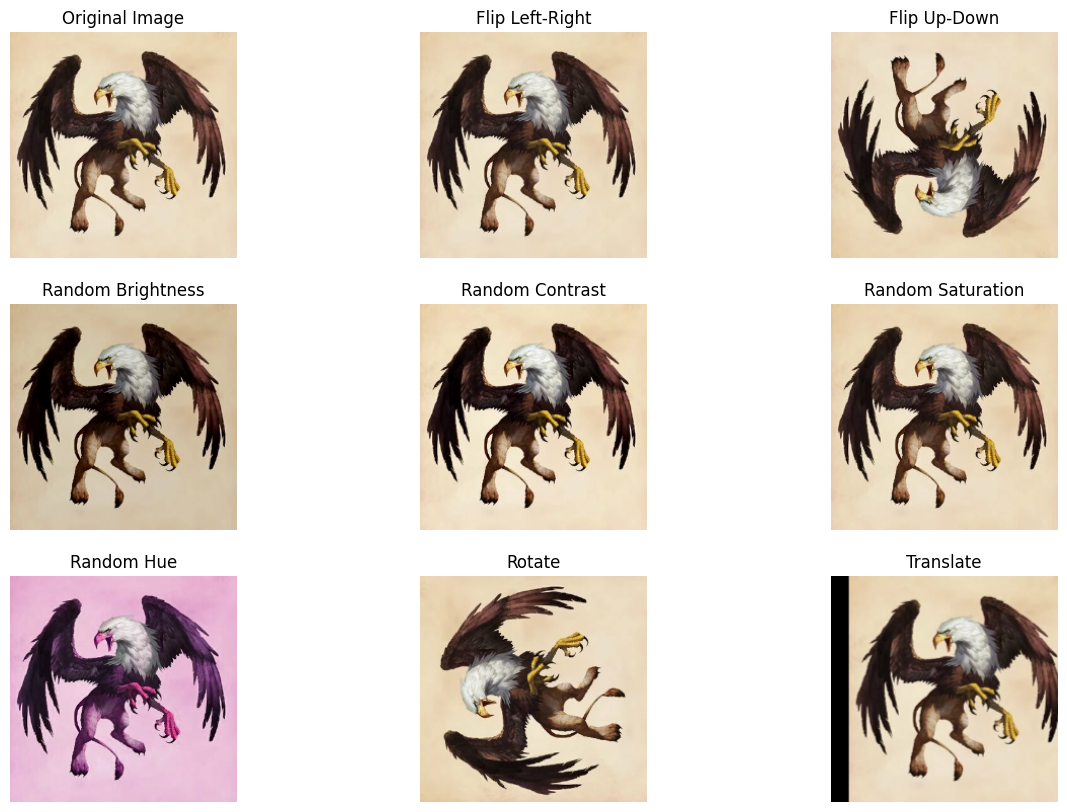

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

def visualize_augmentation(image_path):
    original_image = tf.io.read_file(image_path)
    original_image = tf.image.decode_jpeg(original_image, channels=3)
    original_image = tf.image.convert_image_dtype(original_image, tf.float32)
    original_image = tf.image.resize(original_image, size=[IMG_SIZE, IMG_SIZE])

    augmented_images = []
    techniques = []

    # Flip left-right
    augmented_image = tf.image.random_flip_left_right(original_image)
    augmented_images.append(augmented_image)
    techniques.append("Flip Left-Right")

    # Flip up-down
    augmented_image = tf.image.random_flip_up_down(original_image)
    augmented_images.append(augmented_image)
    techniques.append("Flip Up-Down")

    # Random brightness
    augmented_image = tf.image.random_brightness(original_image, max_delta=0.3)
    augmented_images.append(augmented_image)
    techniques.append("Random Brightness")

    # Random contrast
    augmented_image = tf.image.random_contrast(original_image, lower=0.7, upper=1.3)
    augmented_images.append(augmented_image)
    techniques.append("Random Contrast")

    # Random saturation
    augmented_image = tf.image.random_saturation(original_image, lower=0.7, upper=1.3)
    augmented_images.append(augmented_image)
    techniques.append("Random Saturation")

    # Random hue
    augmented_image = tf.image.random_hue(original_image, max_delta=0.3)
    augmented_images.append(augmented_image)
    techniques.append("Random Hue")

    # Rotate
    augmented_image = tf.image.rot90(original_image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    augmented_images.append(augmented_image)
    techniques.append("Rotate")

    # Translate
    translations = tf.random.uniform(shape=[2], minval=-20, maxval=20, dtype=tf.float32)
    transforms = [1, 0, translations[0], 0, 1, translations[1], 0, 0]
    augmented_image = tf.raw_ops.ImageProjectiveTransformV2(
        images=tf.expand_dims(original_image, 0),
        transforms=tf.convert_to_tensor([transforms]),
        output_shape=tf.shape(original_image)[:2],
        interpolation="BILINEAR"
    )[0]
    augmented_images.append(augmented_image)
    techniques.append("Translate")

    plt.figure(figsize=(15, 10))
    plt.subplot(3, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')

    for i, (aug_image, technique) in enumerate(zip(augmented_images, techniques)):
        plt.subplot(3, 3, i+2)
        plt.imshow(aug_image)
        plt.title(technique)
        plt.axis('off')

    plt.show()

# Example usage
image_path = filenames[20]  # Change this to the path of the image you want to visualize
visualize_augmentation(image_path)



## Turning data into batches

In [ ]:
# Create a simple function to return a tuple (image, label)

def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  preprocess the image and returns the tuple (image, label)
  """
  image = process_image(image_path)
  return image, label

In [ ]:
# Define the batch size
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image(x) and label(y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """

  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepatch (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), #filepath
                                               tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turns filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling image
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch




In [ ]:
# Creating training and validation data batches
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [ ]:
# Check out the different attributes of our data batches

train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 5), dtype=tf.bool, name=None)))

In [ ]:
import matplotlib.pyplot as plt

# Create a function for viewing the images in data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from the data batch
  """
  #setup the figure
  plt.figure(figsize=(10,10))
  # Determine the number of images to display (whichever is smaller)
  num_images = min(len(images), 25)
  # Loop through the images to display
  for i in range(num_images):
    # create subplots (5 rows, 5 colums)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as title
    plt.title(unique_labels[labels[i].argmax()])

    # Turn off the grid lines off
    plt.axis("off")


In [ ]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.bool, name=None))>

In [ ]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

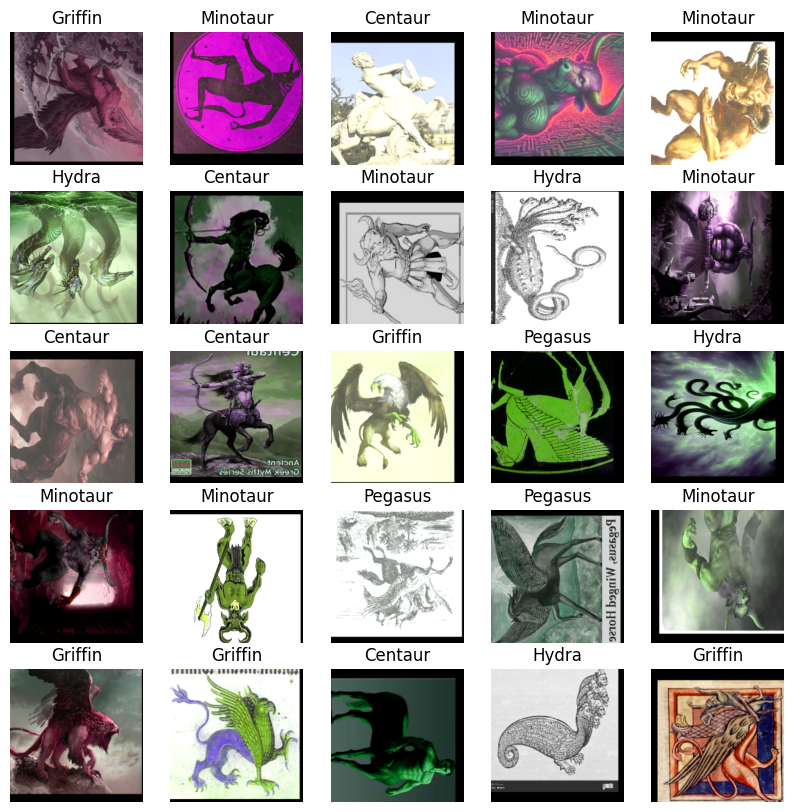

In [ ]:
# NOW LET's visualize the data in training batch
train_images, train_labels = next(train_data.as_numpy_iterator())
show_25_images(train_images, train_labels)

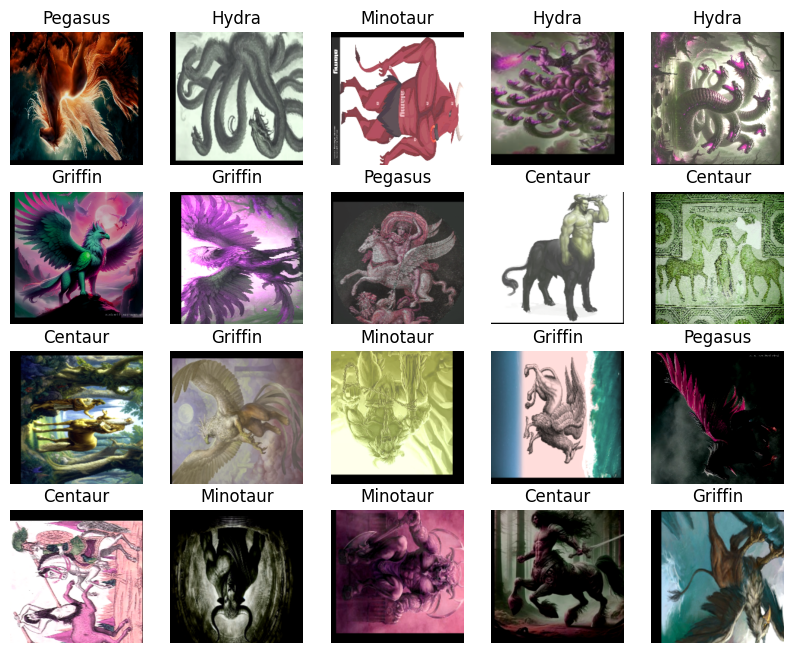

In [ ]:
# Now visualize our validation data

val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are few things we need to define:


*   The input shape (our images shape, in the form of Tensors) to our model
*   The output shape (image labels, in the form of Tensors) to out model
* The url of the model we want to use



In [ ]:
# Setup input shape to the model
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3) # height, width, colour channels

# Setup output shape of the model
OUTPUT_SHAPE = len(unique_labels)

MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
# MODEL_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

Now we have got our inputs, outputs and model ready to go. Let's put them togther into a Keras deep learning model!

Knowing this, let's create a function which:
* Take the input shape, output shape and model we've chosen as a parameters.
* Define the layers in a Keras model in sequential fashion (do this first, then this, then that).
* Compiles the model (says it should be evaluated and improved).
* Builds the model (tells the model the input shape it will be getting).
* Returns the model.


In [ ]:
# Create a sample input tensor
sample_input = tf.random.normal([1] + list(INPUT_SHAPE))

# Load the hub layer
hub_layer = hub.KerasLayer(MODEL_URL, trainable=False)

# Pass the sample input through the hub layer
hub_output = hub_layer(sample_input)

print("Shape after hub layer:", hub_output.shape)


Shape after hub layer: (1, 1280)


In [ ]:
from tensorflow.keras.layers import Layer

# Custom Keras layer to wrap the TensorFlow Hub layer
class HubLayer(Layer):
    def __init__(self, model_url, **kwargs):
        super(HubLayer, self).__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(model_url, trainable=False)

    def call(self, inputs):
        return self.hub_layer(inputs)


In [ ]:
# Create model function
from tensorflow.keras.regularizers import l2

def create_model_tf(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    base_model = HubLayer(model_url, trainable=True)

    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Added L2 regularization
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(output_shape, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [ ]:
model_tf = create_model_tf()
model_tf.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ hub_layer (HubLayer)                 │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1280)                │           5,120 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 663,557 (2.53 MB)

 Trainable params: 660,997 (2.52 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [ ]:
NUM_EPOCHS = 100 #@param {type: "slider", min: 5, max:100, step: 10}

## TensorBoard Callbacks Functions

1. Load the tensorboard notebook extension
2. Create a tensorboard callback which is able to save logs to a directory and pass it to our model's `fit()` function
3. Visualize our model training logs with the tensorboard `%tensorboard` magic function (we'll do after model training)

In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard

In [ ]:
import datetime
import os

# Create a function to build a TensorBoard callback

def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join(
      model_path+"/logs",
      # Make it so that logs get tracked whenever we run an experiment
      'NumEpochs_' + str(NUM_EPOCHS) + '_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  )
  return tf.keras.callbacks.TensorBoard(logdir)

## Early stopping callbacks

Early stopping callbacks helps stop our model from overfitting by stopping training if a certain evaluation metric stops improving.

In [ ]:
# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

# Optional: Replace the custom scheduler with ReduceLROnPlateau for more flexible adjustment
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6, verbose=1
)

# Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10, restore_best_weights=True
)

In [ ]:
# Build a function to train and return a trained model

# Function to train the model
def train_model():
    """
    Trains a given model and returns the trained version.
    """
    # Create a model
    model = create_model_tf()

    # Create a new TensorBoard session (assuming the function is defined elsewhere)
    tensorboard = create_tensorboard_callback()

    # Fit the model to the data passing it the callbacks we created
    history = model.fit(
        train_data,
        epochs=NUM_EPOCHS,
        validation_data=val_data,
        validation_freq=1,
        callbacks=[tensorboard, early_stopping, reduce_lr]  # Replace lr_scheduler with reduce_lr
    )

    # Return the fitted model
    return model, history

In [ ]:
model, history = train_model()

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.1836 - loss: 10.5315 - val_accuracy: 0.4000 - val_loss: 8.9203 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 22s 690ms/step - accuracy: 0.4398 - loss: 9.1722 - val_accuracy: 0.4500 - val_loss: 8.8113 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 535ms/step - accuracy: 0.4984 - loss: 8.9042 - val_accuracy: 0.4500 - val_loss: 8.4167 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 802ms/step - accuracy: 0.5641 - loss: 8.6428 - val_accuracy: 0.4500 - val_loss: 8.2832 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 739ms/step - accuracy: 0.5297 - loss: 8.5606 - val_accuracy: 0.5000 - val_loss: 8.2378 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.5852 - loss: 8.2241 - val_accuracy: 0.6500 - val_loss: 7.9596 - learning_rate: 0.0010
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 549ms/step - accuracy: 0.7383 - loss: 7.8344 - val_acc

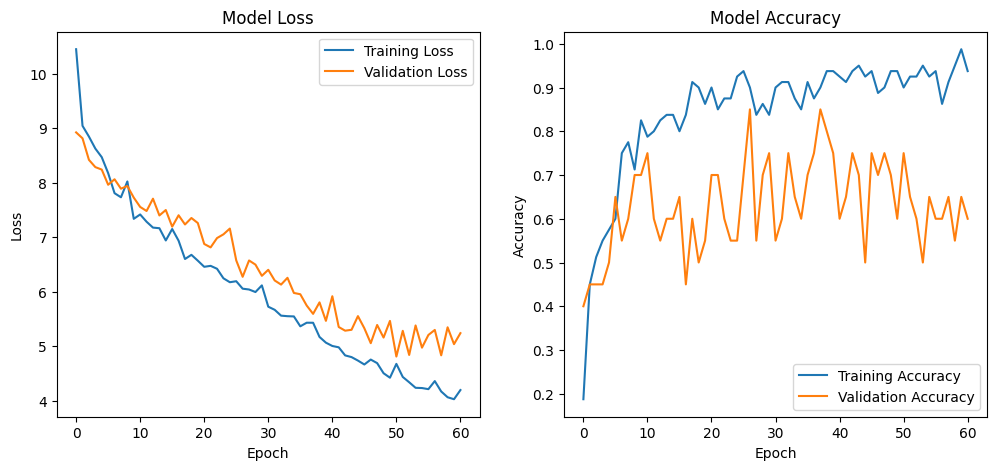

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])

plt.show()


In [ ]:
# TensorBoard logs checker

%tensorboard --logdir drive/My\ Drive/Mythological\ Beast\ CNN/logs

## Making and evaluating predictions using a trained model

In [ ]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.bool, name=None))>

In [ ]:
# Make on the predictions data (not used to train on)

predictions = model.predict(val_data, verbose=1)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


array([[8.06094147e-03, 3.62299085e-02, 2.50453153e-03, 8.44813650e-04,
        9.52359796e-01],
       [7.64627694e-05, 7.33781140e-04, 9.99184549e-01, 4.94553160e-06,
        2.22544784e-07],
       [9.33119595e-01, 1.83140597e-04, 1.57547955e-04, 2.60929987e-02,
        4.04468291e-02],
       [7.55661964e-01, 1.99423695e-04, 2.43342072e-01, 6.39168371e-04,
        1.57391813e-04],
       [4.03904050e-05, 1.16698502e-03, 9.98751760e-01, 3.35625737e-05,
        7.29738122e-06],
       [1.47733444e-04, 7.12508976e-01, 1.06598534e-04, 2.28486912e-04,
        2.87008256e-01],
       [2.04311582e-05, 9.99699712e-01, 1.50452788e-05, 5.91738342e-07,
        2.64270901e-04],
       [8.22703391e-02, 7.17138723e-02, 4.94766563e-01, 7.85718486e-02,
        2.72677332e-01],
       [6.77551746e-01, 1.88096281e-04, 9.04842571e-04, 3.20331335e-01,
        1.02394458e-03],
       [1.76212758e-01, 1.77406043e-01, 4.60828915e-02, 1.46804135e-02,
        5.85617959e-01],
       [1.02596924e-01, 1.8270

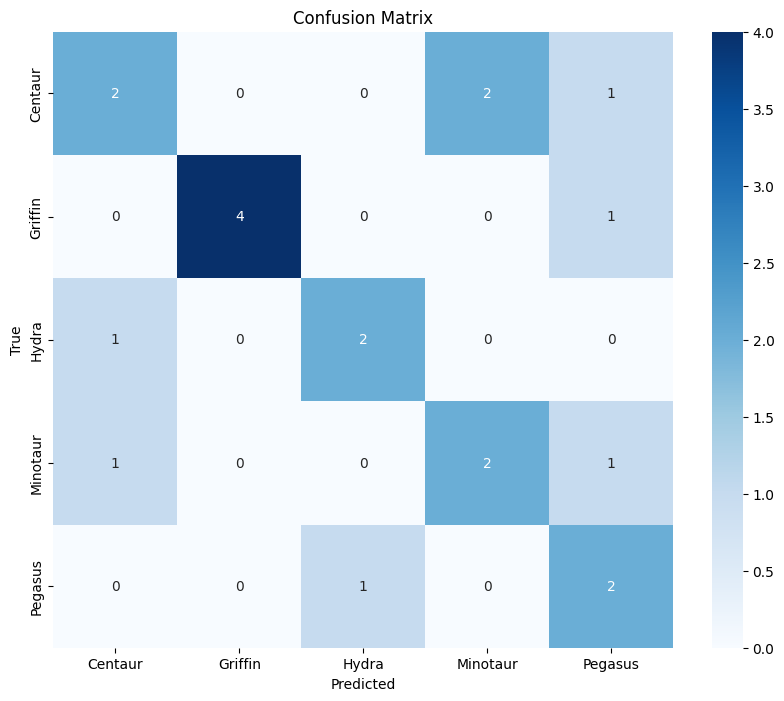

Accuracy: 0.6000
Precision (Macro): 0.6133
F1 Score (Macro): 0.6000
Classification Report:
              precision    recall  f1-score   support

     Centaur       0.50      0.40      0.44         5
     Griffin       1.00      0.80      0.89         5
       Hydra       0.67      0.67      0.67         3
    Minotaur       0.50      0.50      0.50         4
     Pegasus       0.40      0.67      0.50         3

    accuracy                           0.60        20
   macro avg       0.61      0.61      0.60        20
weighted avg       0.64      0.60      0.61        20



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score

# Get the true labels
y_true = []
for _, labels in val_data.unbatch().as_numpy_iterator():
    y_true.append(np.argmax(labels))

# Get the predicted labels
y_pred = np.argmax(predictions, axis=1)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Calculate the precision (macro)
precision = precision_score(y_true, y_pred, average='macro')
print(f"Precision (Macro): {precision:.4f}")

# Calculate the F1 score (macro)
f1 = f1_score(y_true, y_pred, average='macro')
print(f"F1 Score (Macro): {f1:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=unique_labels))


In [ ]:
# Turn predictions probabilites into the label

def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediction probabilities into a label.
  """
  return unique_labels[np.argmax(prediction_probabilities)]

pred_labels = get_pred_label(predictions[0])
pred_labels

'Pegasus'

In [ ]:
get_pred_label(val_labels[0])

'Pegasus'

In [ ]:
def unbatchify(data):
  """
  Takes a batched dataset of (image, label) Tensors and returns seperate arrays of images and labels
  """
  images_batch = []
  labels_batch = []
  for image, label in data.unbatch().as_numpy_iterator():
    images_batch.append(image)
    labels_batch.append(unique_labels[np.argmax(label)])

  return images_batch, labels_batch

# Unbatchify the validation data
images_batch, labels_batch = unbatchify(val_data)
images_batch[0], labels_batch[0]

(array([[[0.26230666, 0.11077337, 0.16962157],
         [0.3227608 , 0.23634145, 0.18084432],
         [0.45082104, 0.42820796, 0.2332564 ],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.22746333, 0.09463316, 0.16245246],
         [0.27126858, 0.17516893, 0.14105858],
         [0.38900766, 0.3735298 , 0.16280442],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        [[0.20095748, 0.08710912, 0.1597741 ],
         [0.24819106, 0.14035039, 0.13451363],
         [0.34310982, 0.30885202, 0.14038731],
         ...,
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]],
 
        ...,
 
        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.     

In [ ]:
def plot_pred(prediction_probabilities, labels, images, n=1):
  """
  View the prediction, ground truth label and image for sample n
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  # Get the pred label
  pred_label = get_pred_label(pred_prob)

  #Plot images and remove ticks
  plt.imshow(image)
  plt.xticks([])
  plt.yticks([])

  # Change the colour based on the prediction is right or wrong
  if pred_label == true_label:
    color = "green"
  else:
    color = "red"

  # Change the plot title
  plt.title("{} {:2.0f}% {}".format(
      pred_label,
      np.max(pred_prob)*100,
      true_label
  ), color = color)

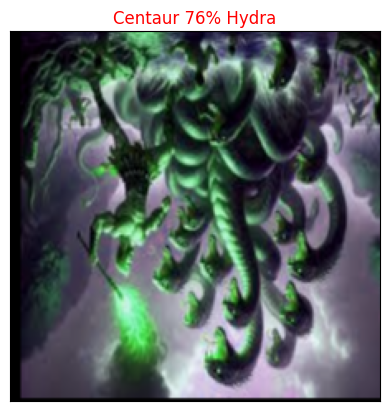

In [ ]:
plot_pred(
    prediction_probabilities=predictions,
    labels=labels_batch,
    images=images_batch,
    n=3)

In [ ]:
def plot_pred_conf(predictions_probabilities, labels, n=1):
  """
  The top 3 highest prediction confidences along with the truth label for sample n
  """

  pred_prob, true_label = predictions_probabilities[n], labels[n]

  # Get the predicted labels
  pred_label = get_pred_label(pred_prob)

  # Find the top 3 prediction confidence indexes
  top_3_pred_indexes = pred_prob.argsort()[-3:][::-1]
  # Find the top 3 prediction confidence values
  top_3_pred_values = pred_prob[top_3_pred_indexes]
  # Find the top 3 prediction labels
  top_3_pred_labels = unique_labels[top_3_pred_indexes]

  # Setup plot
  top_plot = plt.bar(
      np.arange(len(top_3_pred_labels)),
      top_3_pred_values,
      color="grey"
  )
  plt.xticks(np.arange(len(top_3_pred_labels)),
             labels=top_3_pred_labels,
             rotation="vertical")

  # Change the color of true label
  if np.isin(true_label, top_3_pred_labels):
    top_plot[np.argmax(top_3_pred_labels == true_label)].set_color("green")
  else:
    pass

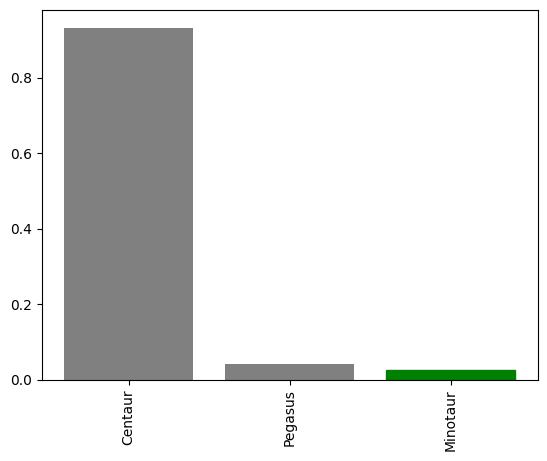

In [ ]:
plot_pred_conf(
    predictions_probabilities=predictions,
    labels=labels_batch,
    n=2
)

In [ ]:
# Few predictions and their different values

i_multiplier = 2
num_rows = 5
num_cols = 2
num_images = num_rows * num_cols
plt.figure(figsize=(10*num_cols, 5*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(
      prediction_probabilities=predictions,
      labels=labels_batch,
      images=images_batch,
      n=i+i_multiplier
  )
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_pred_conf(
      predictions_probabilities=predictions,
      labels=labels_batch,
      n=i+i_multiplier
  )
plt.tight_layout(h_pad=1.0)
plt.show

## Saving and reloading the model

In [ ]:
# Create a function to save a model

def save_model(model, suffix="models"):
  """
  Saves a given model in a models directory and appends a suffix (string)
  """

  # Create a model directory pathname with current time
  modeldir = os.path.join(model_path,
                          "models")

  trained_model_path = modeldir + "/" + suffix + ".h5" # save format of model
  print(f"Saving model to: {trained_model_path}...")
  model.save(trained_model_path)

  return trained_model_path

In [ ]:
from keras.utils import CustomObjectScope

def load_model(model_path):
    """
    Loads a saved model from a specified path
    """
    print(f"Loading saved model from: {model_path}")

    # Define the custom object scope
    custom_objects = {'HubLayer': HubLayer}

    with CustomObjectScope(custom_objects):
        model = tf.keras.models.load_model(
            model_path,
            custom_objects=custom_objects
        )
    return model


In [ ]:
# Save our model trained on 100 images

save_model(model)

Saving model to: drive/MyDrive/Mythological Beast CNN/models/models.h5...


'drive/MyDrive/Mythological Beast CNN/models/models.h5'

In [ ]:
fully_loaded_image_model = load_model(model_path+"/models/models.h5")

Loading saved model from: drive/MyDrive/Mythological Beast CNN/models/models.h5


In [ ]:
# Evaluate the pre saved model

model.evaluate(val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step - accuracy: 0.6500 - loss: 5.1157


[5.115734577178955, 0.6499999761581421]

In [ ]:
# Evaluate the loaded model
fully_loaded_image_model.evaluate(val_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.6500 - loss: 5.1740


[5.174042224884033, 0.6499999761581421]

##Making predictions on the test dataset

In [ ]:
# Load test image filenames
test_path = model_path+"/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]
test_filenames

['drive/MyDrive/Mythological Beast CNN/test/3.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/4.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/5.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/6.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/7.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/1.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/2.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/8.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/9.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/10.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/11.jpeg',
 'drive/MyDrive/Mythological Beast CNN/test/12.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/13.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/14.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/15.jpg',
 'drive/MyDrive/Mythological Beast CNN/test/16.jpg']

In [ ]:
len(test_filenames)

16

In [ ]:
# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [ ]:
test_data

<_BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None)>

In [ ]:
# Make predictions on test data batch using the loaded full model
test_predictions = fully_loaded_image_model.predict(test_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [ ]:
test_predictions.shape

(16, 5)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(test_predictions[i]) for i in range(len(test_predictions))]
custom_pred_labels

['Centaur',
 'Hydra',
 'Minotaur',
 'Griffin',
 'Minotaur',
 'Centaur',
 'Hydra',
 'Minotaur',
 'Hydra',
 'Hydra',
 'Griffin',
 'Minotaur',
 'Hydra',
 'Centaur',
 'Centaur',
 'Griffin']

In [ ]:
# Get custom images (our unbatchify() function won't work since there aren't labels... maybe we could fix this later)
custom_images = []
# Loop through unbatched data
for image in test_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

len(custom_images)

16

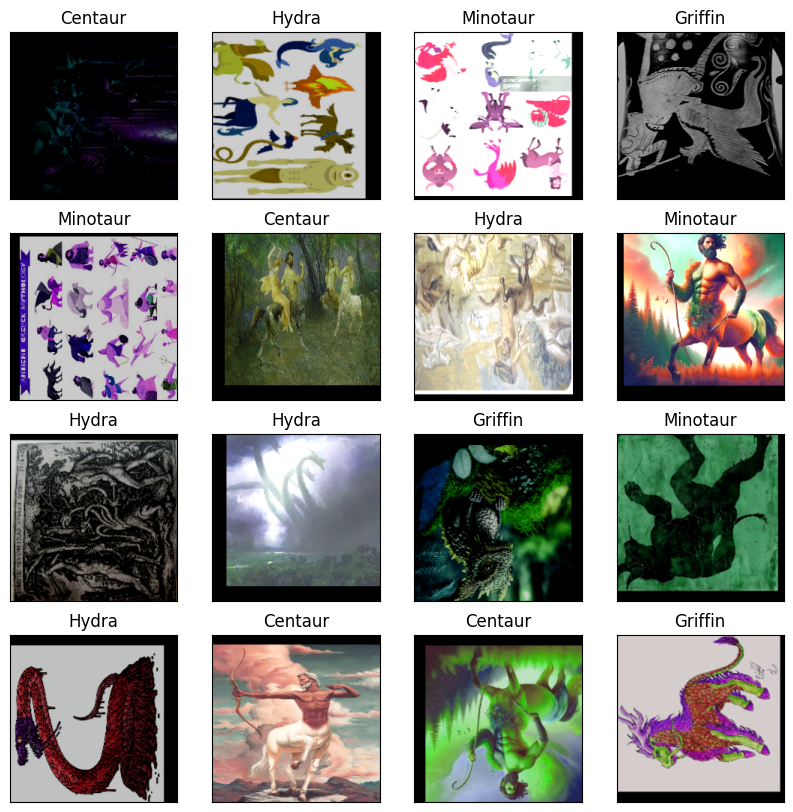

In [ ]:
# Check custom image predictions
plt.figure(figsize=(10, 10))
for i, image in enumerate(custom_images):
  plt.subplot(4, 4, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


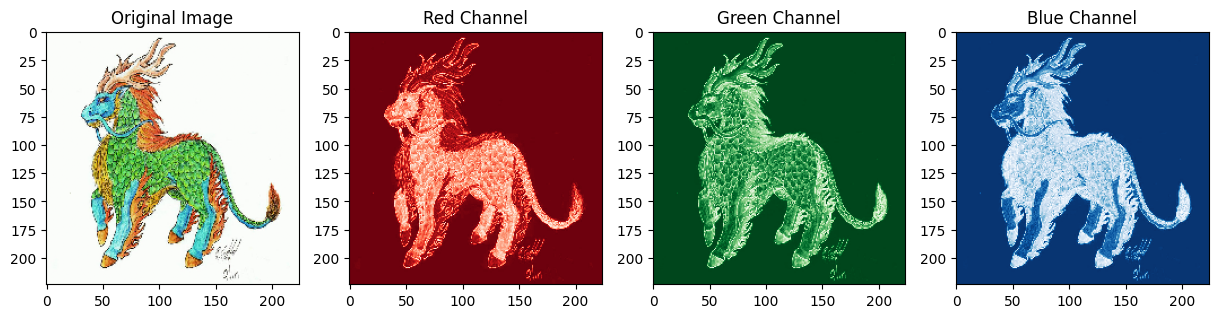

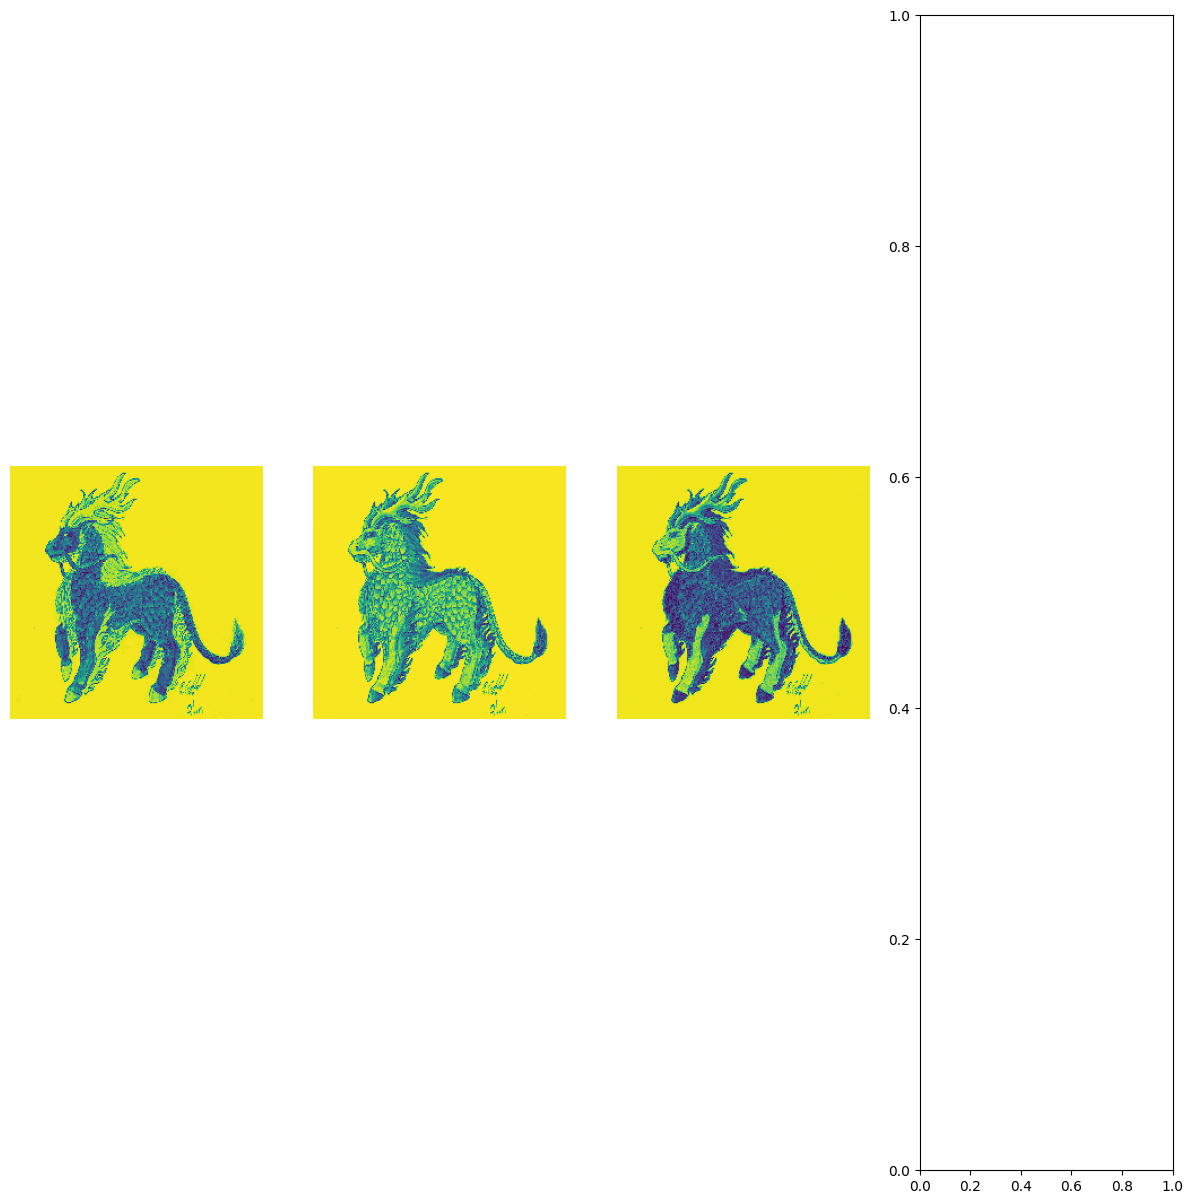

In [ ]:
from tensorflow.keras.preprocessing import image

# Load and preprocess the image
img_path = model_path+'/test/16.jpg'
img = image.load_img(img_path, target_size=(224, 224))  # Adjust size as per your model's input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = img_array / 255.0  # Normalize the image


# Get the model's layers
layer_outputs = [layer.output for layer in fully_loaded_image_model.layers]

# Create a model that outputs each layer's output
activation_model = tf.keras.Model(inputs=fully_loaded_image_model.input, outputs=layer_outputs)

# Get the activations for the given image
activations = activation_model.predict(img_array)

# Visualize the RGB channels of the original image
def plot_rgb_channels(image):
    fig, ax = plt.subplots(1, 4, figsize=(15, 15))
    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[1].imshow(image[:, :, 0], cmap="Reds")
    ax[1].set_title("Red Channel")
    ax[2].imshow(image[:, :, 1], cmap="Greens")
    ax[2].set_title("Green Channel")
    ax[3].imshow(image[:, :, 2], cmap="Blues")
    ax[3].set_title("Blue Channel")
    plt.show()

# Visualize the original image RGB channels
plot_rgb_channels(img_array[0])

# Visualize the activations of the first convolutional layer
first_layer_activation = activations[0]

# Get the number of channels in the first layer's output
num_channels = first_layer_activation.shape[-1]
num_plots = min(16, num_channels)  # Plot up to 16 or less if fewer channels

# Calculate the number of rows needed, ensuring at least one row
num_rows = max(1, num_plots // 4)

# Adjust the grid size accordingly
fig, ax = plt.subplots(num_rows, 4, figsize=(15, 15))

# Handle the case where num_plots is less than 4
ax = ax.flatten()  # Flatten the array to handle single row or column cases

for i in range(num_plots):
    ax[i].imshow(first_layer_activation[0, :, :, i], cmap='viridis')
    ax[i].axis('off')

plt.show()
